# Worksheet

[FORM](https://forms.gle/5HJGU3rPkzqkbHW59)

For this worksheet you'll have to first install [pygraphviz](https://pygraphviz.github.io/documentation/stable/install.html). Then run the following cell without modifying it.

In [5]:
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from networkx import DiGraph, set_node_attributes
from networkx.drawing.nx_agraph import to_agraph
from matplotlib.colors import rgb2hex

COLORS = np.array(['purple', 'blue'])
cvals  = [0, .5, 1]
colors = ['purple', 'white', 'blue']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)

def unique_index(layer, node):
    return str(layer) + "_" + str(node)

class DenseGraph():

    def __init__(self, model):
        self.model = model
        self._graph = self._make_digraph()
        self._graph_original_copy = self._graph.copy()
        self._int_models = self._get_int_models()

    def get_graph(self):
        return self._graph


    def set_graph(self, graph=DiGraph()):
        self._graph = graph
        self._graph_original_copy = self._graph.copy()
        return


    def _reset(self):
        self._graph = self._graph_original_copy.copy()


    def _make_digraph(self):
        graph = DiGraph(nodesep='1', ranksep='1')

        for l in range(len(self.model.layers)):
            layer = self.model.layers[l]

            if type(layer) != keras.layers.Dense:
                raise ValueError("Unsupported Layer Type: %s Only Dense Layers are Supported", type(layer))

            if l == 0:
                for inp in range(layer._input_shape_arg[0]):
                    graph.add_node(
                        unique_index(l, inp),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                inp += 1
            out = layer.units

            for h in range(out):
                if l == len(self.model.layers) - 1:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#3498db",
                        label=''
                    )
                else:
                    graph.add_node(
                        unique_index(l+1, h),
                        shape="circle",
                        color="#2ecc71",
                        label=''
                    )
                for prev in range(inp):
                    graph.add_edge(
                        unique_index(l, prev),
                        unique_index(l + 1, h),
                        color="#B20000"
                    )
            inp = layer.units
        return graph


    def _get_int_models(self):
        """
        Creates a list of models where each model consists of all the layers
        (with matching weights and activations) in self.model up to a specified
        layer depth. This is important to get each node activation.
        """
        intermediate_models = []

        for l in range(len(self.model.layers)):
            int_model = keras.Sequential()
            inp = self.model.layers[0]._input_shape_arg[0]
            
            for prev_layer in range(l + 1):
                int_layer = self.model.layers[prev_layer]
                int_model.add(keras.layers.Dense(
                    int_layer.units,
                    input_dim=inp,
                    activation=int_layer.activation)
                )
                int_model.layers[prev_layer].set_weights(int_layer.get_weights())
                inp = int_layer.units
            int_model.compile(loss=self.model.loss)
            intermediate_models.append(int_model)

        return intermediate_models


    def _snap(self, filename):
        """
        Take snapshot image of the graph
        """
        out = to_agraph(self._graph)
        out.layout(prog='dot')
        out.draw(filename + '.png')
        return np.asarray(im.open(filename + '.png'))

    def animate_activations(self, X, filename='activations', duration=1000, x_color="#3498db", x_marker="o"):
        """
        Creates an animation of the graph activated by each data point
        """
        network_images = []

        predictions = [X]
        for i in range(len(self._int_models)):
            predictions.append(self._int_models[i].predict(X))
        predictions.append(self.model.predict(X))

        for i in range(len(X)):
            for l in range(len(self.model.layers)):
                if l == 0:
                    inp = self.model.layers[l]._input_shape_arg[0]
                else:
                    inp = self.model.layers[l-1].units
                for n in range(0, inp):
                    act = predictions[l][i][n]
                    index = unique_index(l, n)
                    if l == 0:
                        set_node_attributes(self._graph, {
                            index: {
                                'label' : " " + f"{act:.2f}" if act > 1 else " " + f"{act:.2f}".zfill(4) if act > 0 else f"{act:.2f}".zfill(4) if act > -1 else f"{act:.2f}"
                            }})
                    else:
                        # not used in the context of logistic regression
                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

                for h in range(0, self.model.layers[l].units):
                    if l == len(self.model.layers) - 1:
                        act = predictions[l + 1][i][h]
                        index = unique_index(l + 1, h)

                        set_node_attributes(self._graph, {
                            index: {
                                'style': 'filled',
                                'color': str(rgb2hex(CMAP(act)))
                            }})

            network_images.append(self._snap(filename))
            self._reset()
        
        self._convert_gif(network_images, filename, duration)

        return
    
    def _convert_gif(self, imgs, filename, duration):
        stacked_images = []
        for img in imgs:
            stacked_images.append(im.fromarray(np.asarray(img)))

        stacked_images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=stacked_images[1:],
            loop=0,
            duration=duration
        )

        return

    def render(self, filename='graph'):
        """
        Creates a visualization of the graph for a Sequential Dense keras model
        """
        self._snap(filename)
        return

class LR():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename, func):
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        meshData = np.c_[xx.ravel(), yy.ravel()]

        fig, ax = plt.subplots(frameon=False)
        ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), s=100, alpha=.9)
        Z = self.model.predict(func(meshData))
        Z = np.array([z[0] for z in Z]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, func=lambda x: x, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(func(X), Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename, func)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


class LR3D():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename):

        weights, bias = self.model.layers[0].get_weights()
        w1, w2, w3 = weights[:, 0]
        b = bias[0]

        h = .5
        xx, yy = np.meshgrid(np.arange(-3.5, 3.5, h), np.arange(-3.5, 3.5, h))
        zz = -(w1 / w3) * xx - (w2 / w3) * yy - (b / w3)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(10, 80)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(0, 12)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=COLORS[Y].tolist(), s=30, alpha=.5)
        ax.plot_surface(xx, yy, zz, color='orange', alpha=0.3)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y, snap_freq=10, filename='learn', duration=1000, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(X, Y, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model


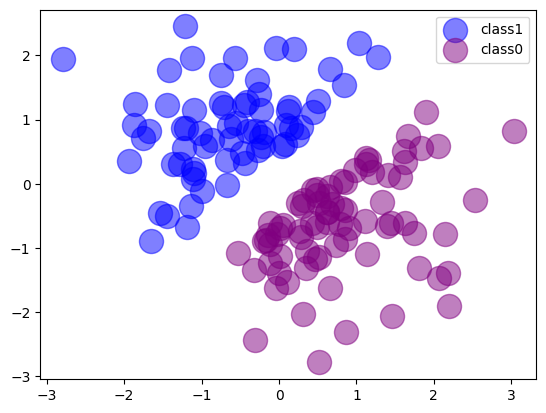

In [7]:
import sklearn.datasets as datasets

np.random.seed(1)

CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, DATA)))
Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'lr', 100, epochs=400)

obj = DenseGraph(model)
obj.render('lr_graph')
obj.animate_activations(X[Y==0], 'lr_graph_activations', duration=100)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.2390
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.2368
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.2399
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.2360
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.2441
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.2251
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.2361
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.2346
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.2290
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.2384
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.2384
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.2302
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.2386
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.2246
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 647us

In [11]:
obj = DenseGraph(model)
obj.render('lr_graph')
obj.animate_activations(X[Y==1], 'lr_graph_activations', duration=100)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepWARNING:tensorflow:5 out of the last 130075 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x37493c4a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


In [12]:
obj = DenseGraph(model)
obj.render('lr_graph')
obj.animate_activations(X, 'lr_graph_activations', duration=100)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


## Non-Linearly Separable

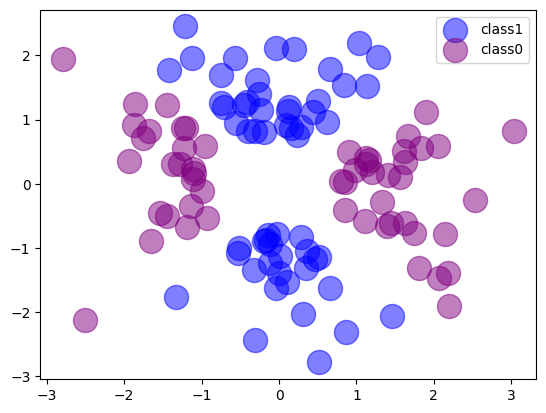

In [27]:
w1 = 1 
w2 = -1
b = 0

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
# X = np.stack([abs(X[:,0]),abs(X[:,1])]).T
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Find new features X1 and X2 that make the data linearly separable. Animate the learned decision boundary throughout gradient descent in that feature space.

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(abs(X), Y, 10, 'abs_lr', 100, epochs=400)

Epoch 1/10


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.1160
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.0703
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 1.1953
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 1.1243
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.04831
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 1.1700
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 1.1650
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.1289
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 1.1611
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.1710
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1180  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1587  
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 1.1529
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.0744
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss

<Sequential name=sequential_11, built=True>

Animate the learned decision boundary throughout gradient descent in the original space.

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
obj.animate_learning(X, Y, 10, 'squ_lr', 100, lambda x : x ** 2, epochs=400)

Epoch 1/10


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.7590
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.7700
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.7602
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7631
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7043  
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.7723
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.7420
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.7475
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.7797
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.7618
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 177us/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.7404
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.7187
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.7417
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.7642
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss:

<Sequential name=sequential_15, built=True>

## Higher Dimension

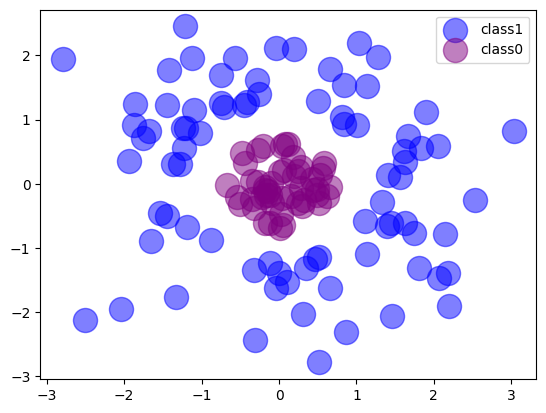

In [30]:
w1 = -1 
w2 = -1
b = 1

X = np.array(list(filter(lambda x : w1 * x[0]**2 + w2 * x[1]**2 + b < -.5 or w1 * x[0]**2 + w2 * x[1]**2 + b > .5, DATA)))
Y = np.array([0 if w1 * x[0]**2 + w2 * x[1]**2 + b >= 0 else 1 for x in X])
class1 = X[Y==1]
class0 = X[Y==0]
plt.scatter(class1[:,0], class1[:,1], color=COLORS[1], s=300, alpha=.5, label='class1')
plt.scatter(class0[:,0], class0[:,1], color=COLORS[0], s=300, alpha=.5, label='class0')
plt.legend()
plt.show()

Add a new feature to X to make the data linearly separable in 3D

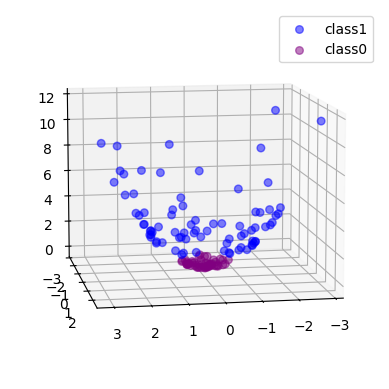

In [32]:
X = np.column_stack((X, X[:,0]**2+ X[:,1]**2))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
class1 = X[Y==1]
class0 = X[Y==0]
ax.view_init(10, 80)
ax.scatter(class1[:,0], class1[:,1], class1[:,2], color=COLORS[1], s=30, alpha=.5, label='class1')
ax.scatter(class0[:,0], class0[:,1], class0[:,2], color=COLORS[0], s=30, alpha=.5, label='class0')
ax.legend()
plt.show()

Animate the learning process through gradient descent in 3D.

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, input_dim=3, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR3D(model)
obj.animate_learning(X, Y, 10, 'lr_3D', 100, epochs=600)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.6970
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.6592
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.6816
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.6572
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.6423
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.6677
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 0.6876
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.6326
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.6466
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.6444
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.6295
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.6221
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.6220
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.6334
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.6321
Epoch 6/10
5/5 ━━━━━━━━━

<Sequential name=sequential_17, built=True>

Come up with a new example of a complex decision boundary that either requires new features or additional features or both. Animate the learned decision boundary. Also animate the graph representation of the logistic regression model as you feed it points only from class0.

Submit both gifs in the form

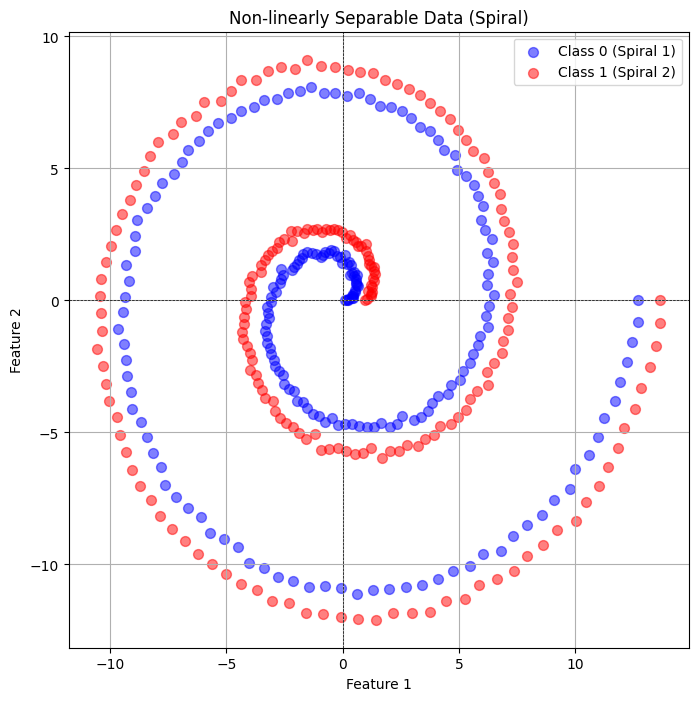

In [39]:
# 데이터 생성 (예: 나선형 데이터)
np.random.seed(0)
num_points = 200

# 클래스 0: 나선형 형태
theta0 = np.linspace(0, 4 * np.pi, num_points)
r0 = theta0 + np.random.normal(0, 0.1, num_points)
x0 = r0 * np.cos(theta0)
y0 = r0 * np.sin(theta0)

# 클래스 1: 나선형 형태
theta1 = np.linspace(0, 4 * np.pi, num_points)
r1 = theta1 + 1 + np.random.normal(0, 0.1, num_points)
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

# 데이터 결합
X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
Y = np.array([0] * num_points + [1] * num_points)

# 시각화
plt.figure(figsize=(8, 8))
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', s=50, alpha=0.5, label='Class 0 (Spiral 1)')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='red', s=50, alpha=0.5, label='Class 1 (Spiral 2)')
plt.title('Non-linearly Separable Data (Spiral)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

In [44]:
obj = DenseGraph(model)
obj.render('spiral_lr_graph')
obj.animate_activations(X, 'spiral_lr_graph_activations', duration=100)

ValueError: Layer dense_23 weight shape (2, 1) is not compatible with provided weight shape (5, 1).

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(5,)))  # Input layer with shape (5,)
model.add(keras.layers.Dense(1, input_dim=2, activation="sigmoid"))
model.compile(loss="binary_crossentropy")

obj = LR(model)
X_transformed = np.column_stack((X, X[:, 0] * X[:, 1], X[:, 0] ** 2, X[:, 1] ** 2))
obj.animate_learning(X, Y, 10, 'spiral_lr', 100, lambda x: np.column_stack((x, x[:, 0] * x[:, 1], x[:, 0] ** 2, x[:, 1] ** 2)), epochs=100)

Epoch 1/10


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 10.8307
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 10.4534
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 11.1876
Epoch 4/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 10.7539
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 9.7849
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 11.4700
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 9.4446
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 8.8152
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 8.4465
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 8.5410
43816/43816 ━━━━━━━━━━━━━━━━━━━━ 8s 182us/step
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 9.2468
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 9.6369 
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 8.9393
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 8.3772
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 8.2835
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 8.6582
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 6.9047
Epoch 8/10
13/13 ━━━━━

<Sequential name=sequential_22, built=True>